In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [119]:
def f(x):
  return 3*x**3 -4*x**2 +5*x -5

In [120]:
f(10.0)

2645.0

In [121]:
xs=np.arange(-10,20,1)
ys=f(xs)
xs
ys

array([-3455, -2561, -1837, -1265,  -827,  -505,  -281,  -137,   -55,
         -17,    -5,    -1,    13,    55,   143,   295,   529,   863,
        1315,  1903,  2645,  3559,  4663,  5975,  7513,  9295, 11339,
       13663, 16285, 19223])

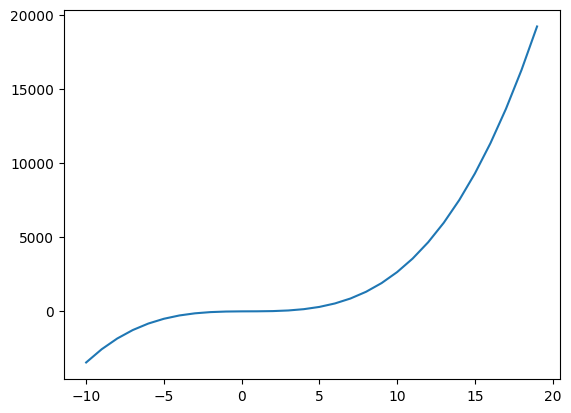

In [122]:

plt.plot(xs,ys)


In [123]:
h=0.0000000001
x=10.0

(f(x+h)-f(x))/h

825.0026439782232

In [124]:
class Value:
  def __init__(self,data, _children=(), _op='',label=''):
    self.data= data
    self._prev= set(_children)
    self._op=_op
    self.grad=0.0
    self._backward= lambda: None # a function that does nothing by default. Later on, used for automatic backprop for each node and its children
    # we use backward function for each operation for all nodes, to track how a resulting node is affected by chain rule wrt the previous nodes, during backprop
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      self.grad=1* out.grad # chain rule for addition; the local derivatives over the addition operation
      other.grad=1* out.grad

    out._backward=_backward

    return out


  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data * other.data,(self,other),'*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad= self.data * out.grad

    out._backward= _backward

    return out

  def tanh(self):  #activation function
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t, (self, ), 'tanh')

    def _backward():
      self.grad= (1-t**2) * out.grad

    out._backward=_backward
    return out

a=Value(2.0,label='a')
b=Value(3.0,label='b')
c=Value(10.0,label='c')
e=a+b
e.label='e'
d=e+c
d.label='d'
f=Value(2.0,label='f')
L=d+f
L.label='L'

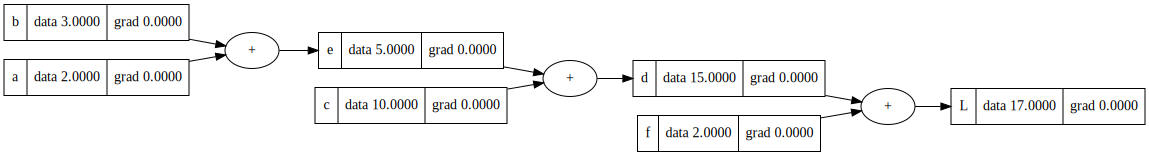

In [125]:

from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

In [126]:
#backprop neuron method

#inputs x1,x2

x1= Value(4.0,label='x1')
x2=Value(5.0,label='x2')

#weights

w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

b= Value(6.9,label='b')

x1w1=x1*w1
x1w1.label='x1w1'

x2w2=x2*w2
x2w2.label='x2w2'

x1w1x2w2=x1w1+x2w2
x1w1x2w2.label='x1w1+x2w2'

n=x1w1x2w2 +b
n.label='n'
o=n.tanh()
o.label='o'


In [127]:
#calculating gradients of all nodes wrt to output o

o.grad=1.0

#o= tanh(n)
# do/dn = 1-(tanh(n))**2 = 1-o**2


In [128]:
1-o.data**2


0.9900662908474398

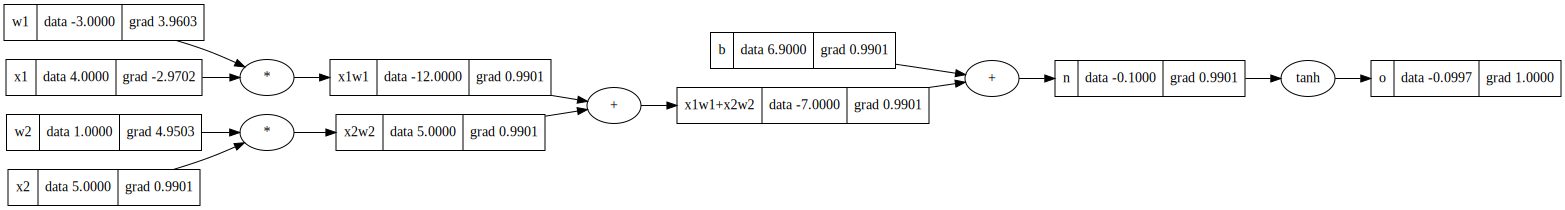

In [129]:
#automated backprop using _backward()
#note: execute this cell while keeping cursor on it,and ctrl+ f9 , to execute only the part meant for autmated backprop. If all cells are executed at same time, the cells below meant for manual backprop mess with values to give different graph values
o.grad=1.0 # setting 1 as by default it is zero
# keep adding _backward() for each node to see how graph changes
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [130]:
b._backward() # returns nothing as it is a leaf node, which is initialized as an empty lambda function


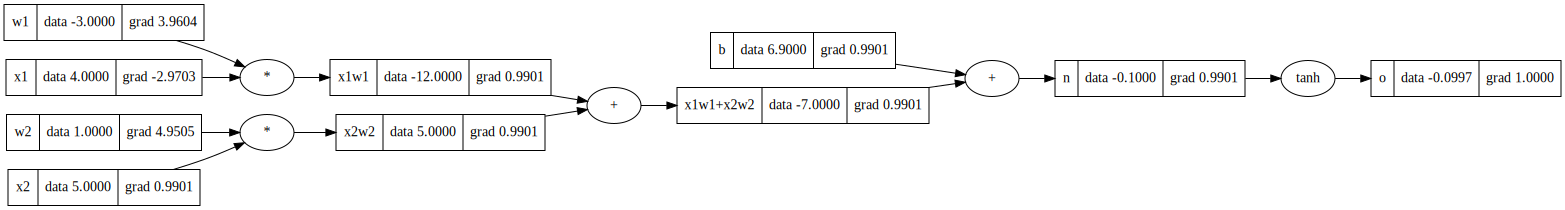

In [131]:
#setting values for manual backprop method
n.grad=0.990066
x1w1x2w2.grad=0.990066  # local derivative over plus operation acts as distributor over the nodes, in our case the child nodes multiply with 1 to give same gradient as n.grad
b.grad=0.990066

x1w1.grad=0.9901
x2w2.grad=0.9901

x2.grad= w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad


draw_dot(o)

In [132]:
#using pytorch

import torch
x1=torch.Tensor([2.0]).double()    ; x1.requires_grad=True #by default pytorch doesnt calculate gradients for maximizing efficiency
x2=torch.Tensor([0.0]).double()    ; x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()    ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double()     ;w2.requires_grad=True

# by default python uses single precision floating point(float32) , hence we use double() for float64 for double precision to keep everything same
b=torch.Tensor([6.8813752398]).double() ; b.requires_grad=True
n=x1*w1 +x2*w2 + b
o=torch.tanh(n)
print(o.data.item())
o.backward()


print('x2', x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())


0.707107644078311
x2 0.49999877968602074
w2 0.0
x1 -1.4999963390580622
w1 0.9999975593720415


In [144]:
#building a neural net
import random
class Neuron:

  def __init__(self,nin):
    self.w= [Value(random.uniform(-1,1)) for _ in range(nin)] # weights w1,w2... generated randomly
    self.b= Value(random.uniform(-1,1))

  def __call__(self,x):
    # w*x + b

    act= sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
    # zip in python creates 2 iterations and maps each value to its pair in a list structure, hence w1 mapped to x1, and so on...
    out=act.tanh()
    return out

#x=[2.0,3.0]  # our 2 inputs
#n=Neuron(2)  # a 2D neuron( takes 2 inputs)
#n(x)


class Layer:
  def __init__(self,nin,nout): # nout decides number of neurons in our layer
    self.neurons = [Neuron(nin) for _ in range(nout)]  # our layer is a list of neurons

  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

#x=[2.0,3.0,-6.0]
#n= Layer(2,3)
#n(x)   #this creates one layer of 3 neurons where each neuron takes 2 inputs

class MLP:   #multi-layer perceptron
  def __init__(self,nin,nouts): # nouts takes list of multiple neurons in different layers
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

x=[2.0,-10.0,30.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.05453240763807508)

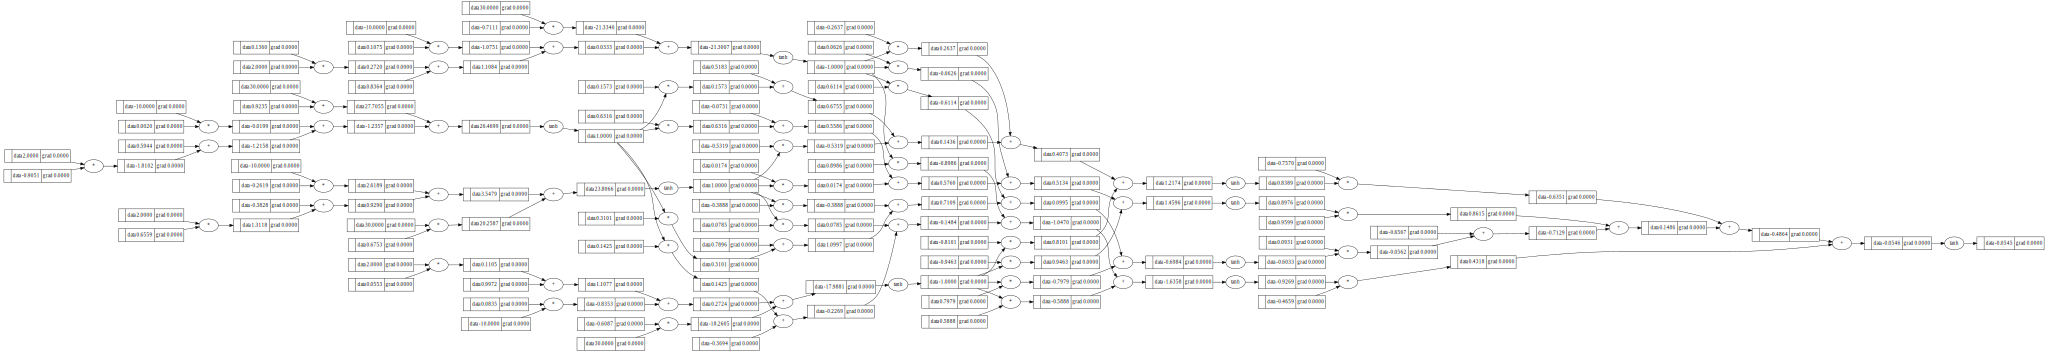

In [145]:
draw_dot(n(x))